First figure of the manuscript, introductory. 
- examples of raw traces (both LFP and gamma) during wake and sleep.
- associated ACF and PSD during sleep stages
- accompanying fits on the functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy import signal
import pickle
from ast import literal_eval
import matplotlib.pyplot as plt
from nilearn import surface as nisurf
import plotly.graph_objects as go

from mnitimescales import plots, Load

plots._set_font_params()

Paths and names:

In [3]:
data_path = Path("F:\\MNIOpen")
mat_file = data_path.joinpath("Data", "Raw", "MatlabFile.mat")
tau_path = data_path.joinpath("Results", "timescales_broadband")
gamma_path = data_path.joinpath("Results", "timescales_gamma")
fig_path = data_path.joinpath("Figures", "Fig_intro")
fig_path.mkdir(parents=True, exist_ok=True)
surfaces_dir = Path("C:/Users/ricca/mne_data/MNE-sample-data/subjects/fsaverage/surf")

Get data and info:

In [4]:
# data = loadmat(data_path.joinpath("MatlabFile.mat"))
# data_W = data["Data_W"].T
# data_N2 = data["Data_N2"].T
# data_N3 = data["Data_N3"].T
# data_R = data["Data_R"].T

# # Export info as a dataframe
# ch_names = data["ChannelName"].squeeze()
# ch_types = data["ChannelType"].squeeze()
# ch_regs = data["ChannelRegion"].squeeze()
# pat_ids = data["Patient"].squeeze()
# gender = data["Gender"].squeeze()
# age = data["AgeAtTimeOfStudy"].squeeze()
# ch_pos = data["ChannelPosition"].squeeze()
# regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
# sfreq = data["SamplingFrequency"][0][0]
# df_info = pd.DataFrame(
#     {
#         "pat": pat_ids,
#         "chan": [ch[0] for ch in ch_names],
#         "type": [t[0] for t in ch_types],
#         "region": ch_regs,
#         "mni_x": ch_pos[:, 0],
#         "mni_y": ch_pos[:, 1],
#         "mni_z": ch_pos[:, 2],
#     }
# )

load = Load(mat_file)
df_info = load.get_info()
data = load.raw_data.copy()
data_W = data["Data_W"].T
data_N2 = data["Data_N2"].T
data_N3 = data["Data_N3"].T
data_R = data["Data_R"].T

Selected patients and channels to plot:

In [63]:
# Patients and channels to use
pats = [34, 34] # [78, 78]  # [34, 34]
chans = ["GD034Lr_3", "GD034Lu_2"] # ["MM078LOF3", "MM078LH8"]  # ["GD034Lr_3", "GD034Lu_2"]
lobes = ["Frontal", "Temporal"]

Define names and colors:

In [64]:
stages_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}

### A) Plot overview of all channels in the dataset:

In [34]:
# Load surface
surface_left = nisurf.load_surf_mesh(surfaces_dir.joinpath("lh.pial"))
surface_left_faces = surface_left.faces.astype(int)
surface_right = nisurf.load_surf_mesh(surfaces_dir.joinpath("rh.pial"))
surface_right_faces = surface_right.faces.astype(int)

# First, create surface plot
surf_left = go.Mesh3d(
    x=surface_left.coordinates[:, 0],
    y=surface_left.coordinates[:, 1],
    z=surface_left.coordinates[:, 2],
    i=surface_left_faces[:, 0],
    j=surface_left_faces[:, 1],
    k=surface_left_faces[:, 2],
    color="gainsboro",
    opacity=0.2,
    hoverinfo="skip",
    showscale=False,
)
surf_right = go.Mesh3d(
    x=surface_right.coordinates[:, 0],
    y=surface_right.coordinates[:, 1],
    z=surface_right.coordinates[:, 2],
    i=surface_right_faces[:, 0],
    j=surface_right_faces[:, 1],
    k=surface_right_faces[:, 2],
    color="gainsboro",
    opacity=0.2,
    hoverinfo="skip",
    showscale=False,
)

# Then, the scatterplot
scatter_trace = go.Scatter3d(
    x=df_info["mni_x"],
    y=df_info["mni_y"],
    z=df_info["mni_z"],
    mode="markers",
    marker=dict(
        size=2,
        color="black",
        opacity=0.8,
    ),
    hoverinfo="skip",
)

#  Highlight selected channels
mni_coords = df_info.loc[
    df_info["chan"].isin(chans), ["mni_x", "mni_y", "mni_z"]
].to_numpy()
ch_traces = go.Scatter3d(
    x=mni_coords[:, 0],
    y=mni_coords[:, 1],
    z=mni_coords[:, 2],
    mode="markers",
    marker=dict(
        size=10,
        color="#e377c2",
        opacity=0.99,
    ),
    hoverinfo="skip",
)

# Put together the two plots
fig = go.Figure(
    data=[surf_left, surf_right, scatter_trace, ch_traces],
)

# Update the layout
fig.update_layout(
    {
        "paper_bgcolor": "rgba(0,0,0,0)",  # transparent, to make it dark set a=0.8
    },
    scene=dict(
        xaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
        yaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
        zaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    scene_camera=dict(eye=dict(x=0, y=1.5, z=0)),
    showlegend=False,
)

# Frontal view
fig.write_image(fig_path.joinpath(f"Contacts_overview_front.svg"))

# Top view
fig.update_layout(
    scene_camera=dict(eye=dict(x=0, y=0, z=1.5)),
)
fig.write_image(fig_path.joinpath(f"Contacts_overview_top.svg"))

# Lateral view
fig.update_layout(
    scene_camera=dict(eye=dict(x=-1.5, y=0, z=0)),
)
fig.write_image(fig_path.joinpath(f"Contacts_overview_lat.svg"))

(Optional) Prepare data for CORTEO plotting:

In [8]:
df_plot_corteo = pd.DataFrame(
    columns=[
        "type",
        "model",
        "electrode",
        "name",
        "n",
        "color",
        "natus",
        "sm",
        "isOut",
        "isWM",
        "native_x",
        "native_y",
        "native_z",
        "mni_x",
        "mni_y",
        "mni_z",
    ]
)

df_plot_corteo["mni_x"] = df_info["mni_x"].to_numpy()
df_plot_corteo["mni_y"] = df_info["mni_y"].to_numpy()
df_plot_corteo["mni_z"] = df_info["mni_z"].to_numpy()
df_plot_corteo["type"] = "lead"
df_plot_corteo["model"] = df_info["type"].to_numpy()
df_plot_corteo["electrode"] = "ele"
df_plot_corteo["name"] = df_info["chan"].to_numpy()
df_plot_corteo["n"] = np.arange(1, df_info.shape[0] + 1)
df_plot_corteo["color"] = "#000"
df_plot_corteo["natus"] = df_info["chan"].to_numpy()
df_plot_corteo["sm"] = -1
df_plot_corteo["isOut"] = False
df_plot_corteo["isWM"] = False
df_plot_corteo["native_x"] = 0
df_plot_corteo["native_y"] = 0
df_plot_corteo["native_z"] = 0

# Color the electrodes of interest in pink
df_plot_corteo.loc[df_plot_corteo["name"].isin(chans), "color"] = "#e377c2"

df_plot_corteo.to_excel(
    data_path.joinpath("Cohort", "Electrodes", "Lookup.xlsx"), sheet_name="channels"
)

### B) Plot examples of traces:

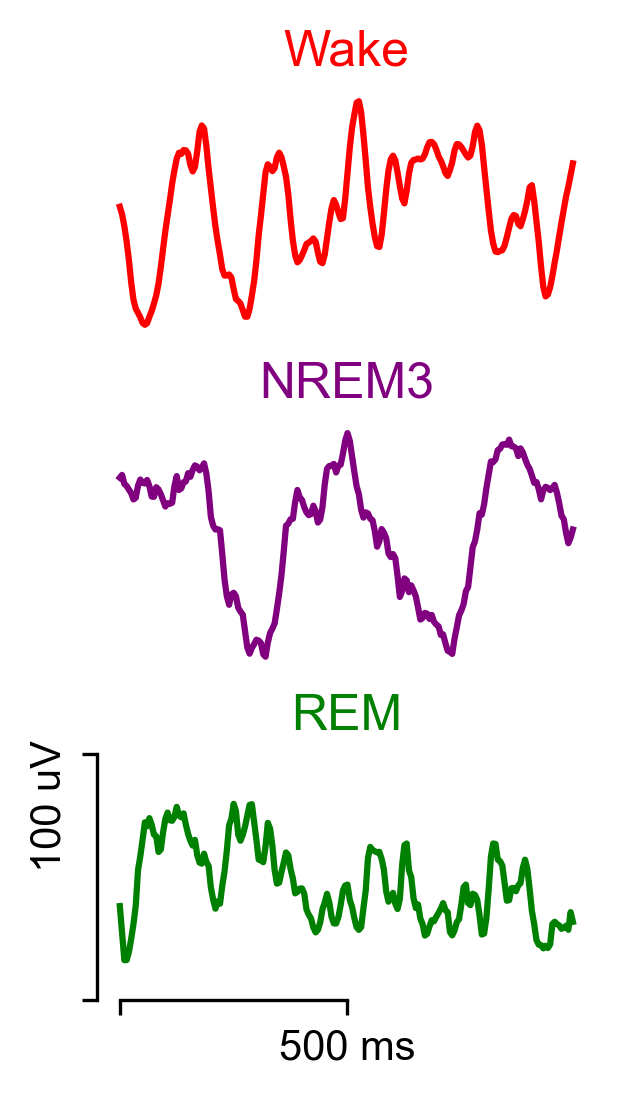

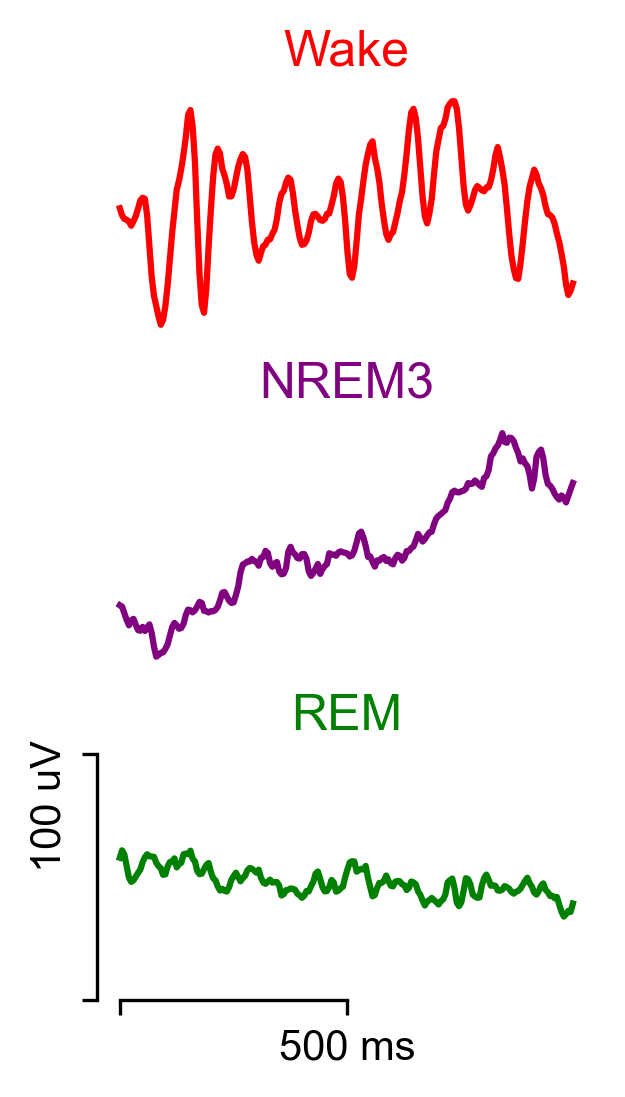

In [55]:
sfreq = data["SamplingFrequency"][0, 0]

# Times for traces plot
t_start = 19
t_end = t_start + 1

# Plot traces
idx_start = int(t_start * sfreq)
idx_end = int(t_end * sfreq)
# Figsize in cm
figsize = (5, 9)
for ch in chans:
    fig, axs = plt.subplots(
        3,
        1,
        figsize=plots._get_figsize_inches(figsize),
        layout="constrained",
        dpi=300,
    )
    idx = df_info.loc[df_info["chan"] == ch].index[0]
    axs[0].plot(data_W[idx, idx_start:idx_end], c=color_stages["W"], label="Wake")
    axs[0].set_title("Wake", fontsize=plots.fsize.TITLE_SIZE)
    axs[0].title.set_color(color_stages["W"])
    axs[1].plot(data_N3[idx, idx_start:idx_end], c=color_stages["N3"], label="NREM3")
    axs[1].set_title("NREM3", fontsize=plots.fsize.TITLE_SIZE)
    axs[1].title.set_color(color_stages["N3"])
    axs[2].plot(data_R[idx, idx_start:idx_end], c=color_stages["R"], label="REM")
    axs[2].set_title("REM", fontsize=plots.fsize.TITLE_SIZE)
    axs[2].title.set_color(color_stages["R"])
    for i in range(3):
        axs[i].spines[["top", "right"]].set_visible(False)
        if i == 2:
            axs[i].set_xticks(
                [0, int(sfreq / 2)],
                labels=["", "500 ms"],
                fontsize=plots.fsize.TICK_SIZE,
                
            )
            axs[i].spines["bottom"].set_bounds(0, int(sfreq / 2))
            axs[i].set_yticks(
                [-50, 50],
                labels=["", "100 uV"],
                fontsize=plots.fsize.TICK_SIZE,
                rotation=90,
            )
            axs[i].spines["left"].set_bounds(-50, 50)
        else:
            axs[i].spines[["bottom", "left"]].set_visible(False)
            axs[i].set_xticks([])
            axs[i].set_yticks([])

    plots.save_figure(fig, fig_path.joinpath(f"traces_{ch}.svg"))      
    plt.show()

### C) Plot ACFs from the channels:

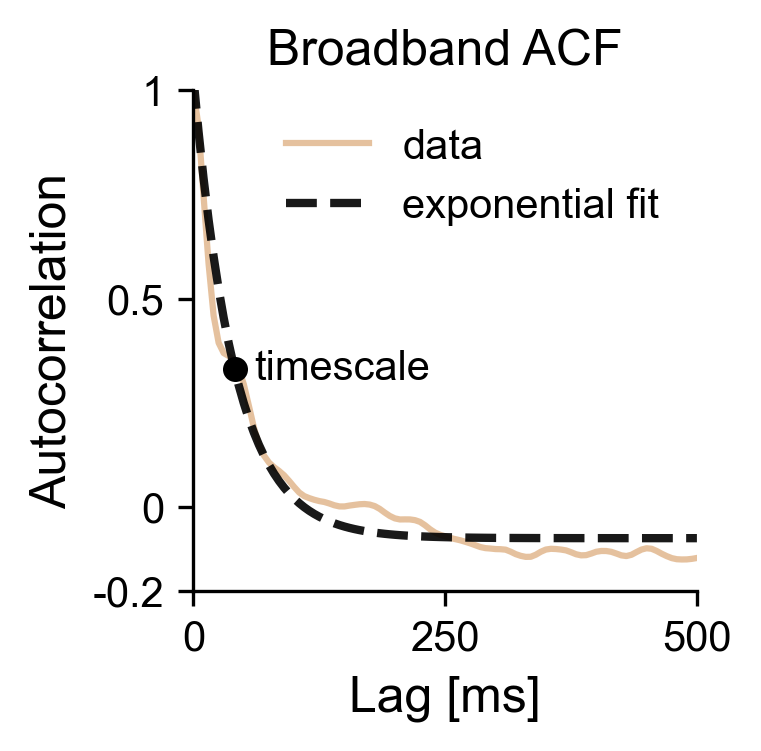

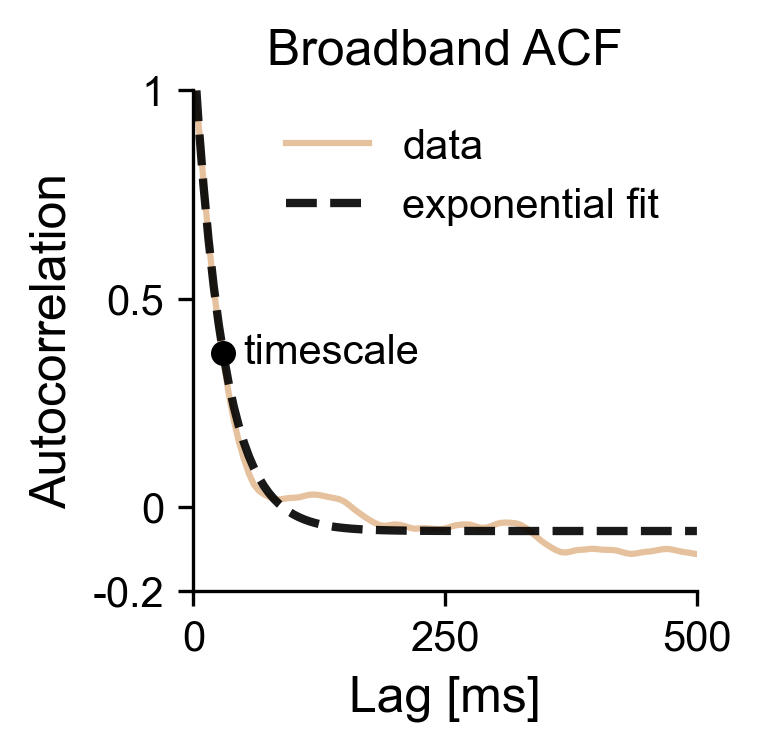

In [65]:
# Figsize in cm
figsize = (5.5, 5.5)

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = tau_path.joinpath("Pats", str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=plots._get_figsize_inches(figsize), dpi=300)

    for stage in ["R"]:  # ["W", "N3", "R"]:
        # Load ACF
        with open(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            acf_pat_stage = pickle.load(f)
        idx_chan = acf_pat_stage["chans"].index(chan)

        # Load fit
        df_fit = pd.read_csv(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage + "_tau.csv"),
            index_col=0,
        )
        params = literal_eval(
            df_fit.loc[chan, "params"]
            .replace("  ", " ")
            .replace("  ", " ")
            .replace("[ ", "[")
            .replace(" ", ",")
        )

        # Figure ACF
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            acf_pat_stage["acf"][:, idx_chan].mean(axis=0),
            c="peru",
            label="data",
            lw=1.5,
            alpha=0.5,
        )
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            params[1] * (np.exp(-acf_pat_stage["lags"] / params[0]) + params[2]),
            c="k",
            ls="--",
            lw=2,
            alpha=0.9,
            label="exponential fit",
        )
        ax.scatter(
            params[0] * 1000,
            params[1] * (1/np.e + params[2]),
            marker="o",
            c="k",
            s=25,
            zorder=5
        )
        ax.annotate(
            "timescale",
            (params[0] * 1000 + 20, params[1] * (1/np.e + params[2])),
            va="center",
            fontsize=plots.fsize.TEXT_SIZE
        )
        # title = " - ".join([str(pat), chan, lobe])
        ax.set_title(
            "Broadband ACF", fontsize=plots.fsize.TITLE_SIZE
        )
        ax.set_xlim(0, 500)
        ax.set_xticks(
            [0, 250, 500],
            labels=[0, 250, 500],
            fontsize=plots.fsize.TICK_SIZE
        )
        ax.set_xlabel(
            "Lag [ms]", fontsize=plots.fsize.LABEL_SIZE
        )
        ax.set_ylim(-0.2, 1)
        ax.set_yticks(
            [-0.2, 0, 0.5, 1],
            labels=[-0.2, 0, 0.5, 1],
            fontsize=plots.fsize.TICK_SIZE
        )
        ax.set_ylabel(
            "Autocorrelation", fontsize=plots.fsize.LABEL_SIZE
        )
        plots._format_spines(ax)
    ax.legend(frameon=False, fontsize=plots.fsize.TEXT_SIZE)

    plots.save_figure(fig, fig_path.joinpath(f"ACF_{pat}_{chan}.svg"))

    plt.show()

ACF of gamma activity

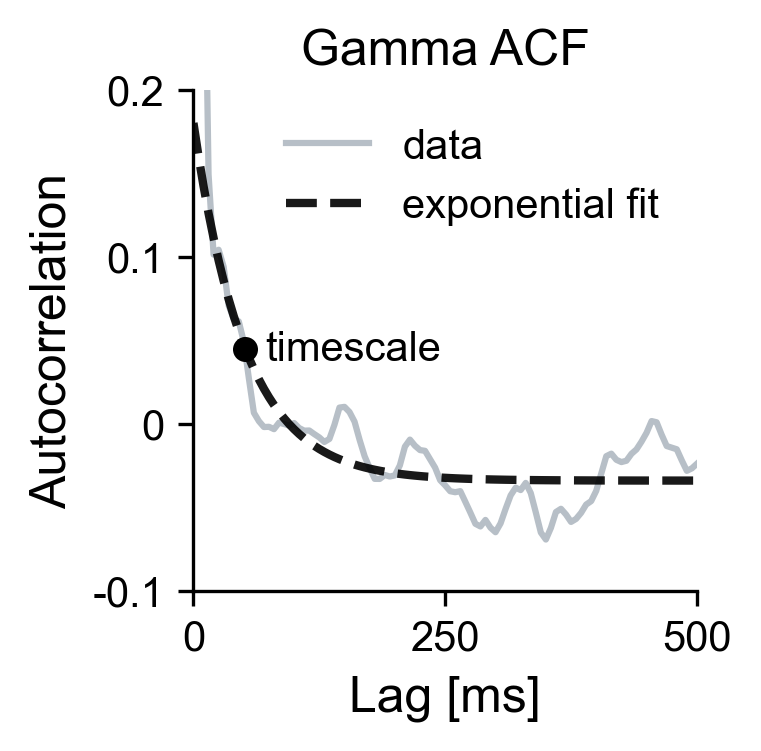

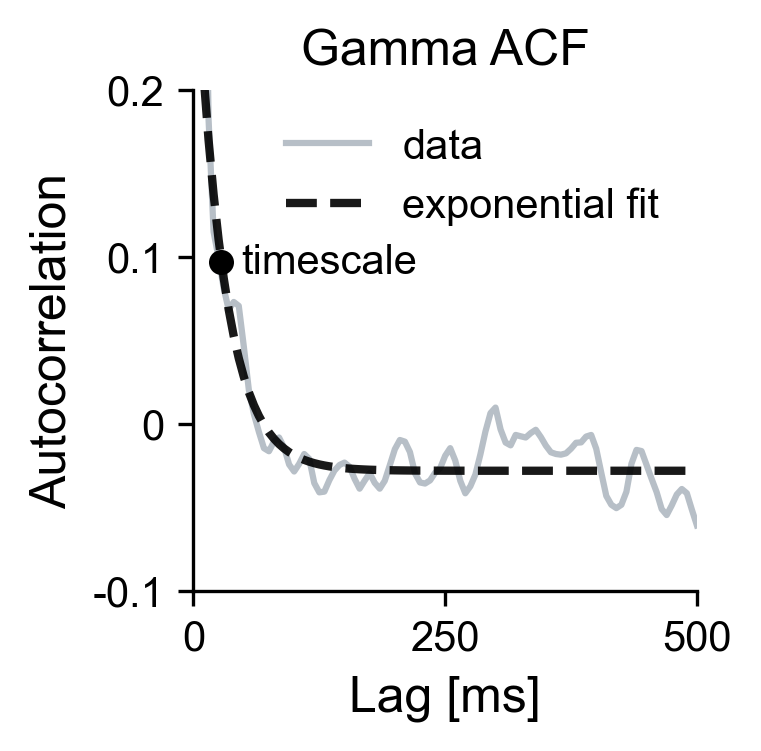

In [66]:
# Figsize in cm
figsize = (5.5, 5.5)

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = gamma_path.joinpath("Pats", str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=plots._get_figsize_inches(figsize), dpi=300)

    for stage in ["W"]:  # , "N3", "R"]:
        # Load ACF
        with open(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            acf_pat_stage = pickle.load(f)
        idx_chan = acf_pat_stage["chans"].index(chan)

        # Load fit
        df_fit = pd.read_csv(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage + "_tau.csv"),
            index_col=0,
        )
        params = literal_eval(
            df_fit.loc[chan, "params"]
            .replace("  ", " ")
            .replace("  ", " ")
            .replace("[ ", "[")
            .replace(" ", ",")
        )

        # Figure ACF
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            acf_pat_stage["acf"][:, idx_chan].mean(axis=0),
            c="slategrey",
            label="data",
            lw=1.5,
            alpha=0.5,
        )
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            params[1] * (np.exp(-acf_pat_stage["lags"] / params[0]) + params[2]),
            c="k",
            ls="--",
            lw=2,
            alpha=0.9,
            label="exponential fit",
        )
        ax.scatter(
            params[0] * 1000,
            params[1] * (1/np.e + params[2]),
            marker="o",
            c="k",
            s=25,
            zorder=5
        )
        ax.annotate(
            "timescale",
            (params[0] * 1000 + 20, params[1] * (1/np.e + params[2])),
            va="center",
            fontsize=plots.fsize.TEXT_SIZE
        )
        # title = " - ".join([str(pat), chan, lobe])
        ax.set_title(
            "Gamma ACF", fontsize=plots.fsize.TITLE_SIZE
        )
        ax.set_xlim(0, 500)
        ax.set_xticks(
            [0, 250, 500],
            labels=[0, 250, 500],
            fontsize=plots.fsize.TICK_SIZE
        )
        ax.set_xlabel(
            "Lag [ms]", fontsize=plots.fsize.LABEL_SIZE
        )
        ax.set_ylim(-0.1, 0.2)
        ax.set_yticks(
            [-0.1, 0, 0.1, 0.2],
            labels=[-0.1, 0, 0.1, 0.2],
            fontsize=plots.fsize.TICK_SIZE
        )
        ax.set_ylabel(
            "Autocorrelation", fontsize=plots.fsize.LABEL_SIZE
        )
        plots._format_spines(ax)
    ax.legend(frameon=False, fontsize=plots.fsize.TEXT_SIZE)

    plots.save_figure(fig, fig_path.joinpath(f"ACF_{pat}_{chan}_gamma.svg"))

    plt.show()

### D) Plot cross correlations:

100%|██████████| 106/106 [00:01<00:00, 103.51it/s]


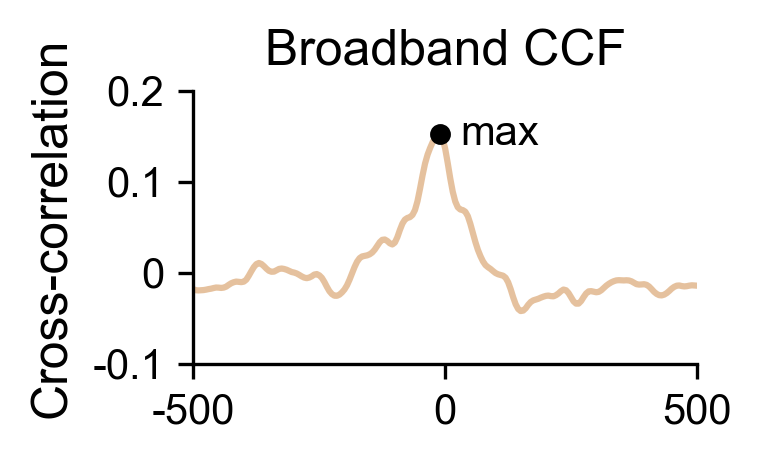

In [50]:
# Figsize in cm
figsize = (5.5, 3)

fig, ax = plt.subplots(figsize=plots._get_figsize_inches(figsize), dpi=300)

for stage, data_stage in zip(
    ["R"], [data_R]
):  # ["W", "N3", "R"], [data_W, data_N3, data_R]):

    epo = load.load_epo_stage(stage)[str(pats[0]).zfill(3)]

    # Get epoched data
    data_ch1 = epo.get_data(picks=chans[0]).squeeze()
    data_ch2 = epo.get_data(picks=chans[1]).squeeze()

    # Compute cross-correlation
    corr_avg = []
    for k in range(len(data_ch1)):
        ch1_norm = (data_ch1[k] - data_ch1[k].mean()) / (np.std(data_ch1[k]) * len(data_ch1[k]))
        ch2_norm = (data_ch2[k] - data_ch2[k].mean()) / (np.std(data_ch2[k]))
        corr = signal.correlate(ch1_norm, ch2_norm, mode="same")
        lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode="same")
        corr_avg.append(corr)
    corr_avg = np.array(corr_avg).mean(axis=0)
    corr_max = np.max(np.abs(corr_avg))
    lag_max = lags[np.argmax(np.abs(corr_avg))]

    # Plot
    ax.plot(
        lags * 1000 / sfreq,
        corr_avg,
        c="peru",
        # label="data",
        lw=1.5,
        alpha=0.5,
    )
    # Max
    ax.scatter(
        lag_max * 1000 / sfreq,
        corr_max,
        c="k",
        s=16,
        # label="max",
        zorder=4,
    )
    ax.annotate("max", (lag_max * 1000 / sfreq + 40, corr_max), fontsize=plots.fsize.TEXT_SIZE,
                va="center")
    # Plot parameters
    ax.set_title(
        "Broadband CCF",
        fontsize=plots.fsize.TITLE_SIZE
    )
    ax.set_xlim(-500, 500)
    ax.set_xticks(
        [-500, 0, 500],
        labels=[-500, 0, 500],
        fontsize=plots.fsize.TICK_SIZE
    )
    ax.set_xlabel("", fontsize=0)
    ax.set_ylim(-0.1, 0.2)
    ax.set_yticks(
        [-0.1, 0, 0.1, 0.2],
        labels=[-0.1, 0, 0.1, 0.2],
        fontsize=plots.fsize.TICK_SIZE
    )
    ax.set_ylabel(
        "Cross-correlation", fontsize=plots.fsize.LABEL_SIZE
    )
    plots._format_spines(ax)

plots.save_figure(fig, fig_path.joinpath(f"CC_{pats[0]}.svg"))
plt.show()

100%|██████████| 106/106 [00:04<00:00, 24.80it/s]


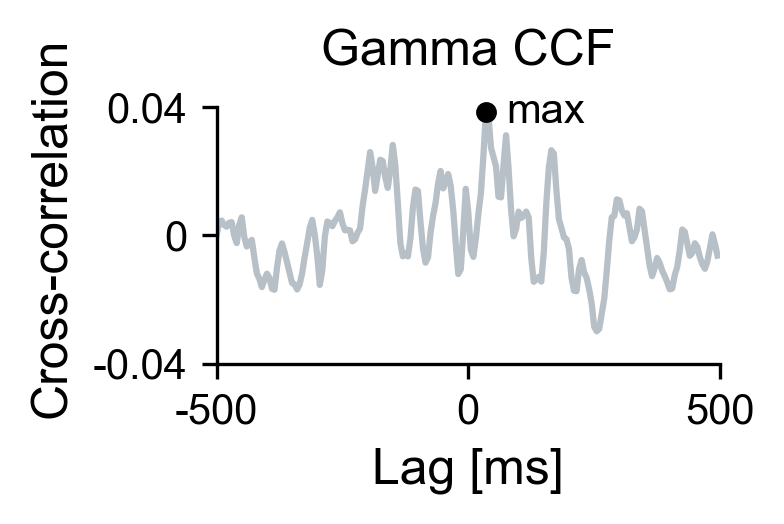

In [53]:
# Figsize in cm
figsize = (5.5, 3)

fig, ax = plt.subplots(figsize=plots._get_figsize_inches(figsize), dpi=300)

for stage, data_stage in zip(
    ["N3"], [data_R]
):  # ["W", "N3", "R"], [data_W, data_N3, data_R]):

    epo = epo = load.load_epo_stage(stage, filt=True, filt_freqs=[40, 80])[str(pats[0]).zfill(3)]

    # Get epoched data
    data_ch1 = epo.get_data(picks=chans[0]).squeeze()
    data_ch2 = epo.get_data(picks=chans[1]).squeeze()

    # Compute cross-correlation
    corr_avg = []
    for k in range(len(data_ch1)):
        ch1_norm = (data_ch1[k] - data_ch1[k].mean()) / (np.std(data_ch1[k]) * len(data_ch1[k]))
        ch2_norm = (data_ch2[k] - data_ch2[k].mean()) / (np.std(data_ch2[k]))
        corr = signal.correlate(ch1_norm, ch2_norm, mode="same")
        lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode="same")
        corr_avg.append(corr)
    corr_avg = np.array(corr_avg).mean(axis=0)
    corr_max = np.max(np.abs(corr_avg))
    lag_max = lags[np.argmax(np.abs(corr_avg))]

    # Plot
    ax.plot(
        lags * 1000 / sfreq,
        corr_avg,
        c="slategrey",
        # label="data",
        lw=1.5,
        alpha=0.5,
    )
    # Max
    ax.scatter(
        lag_max * 1000 / sfreq,
        corr_max,
        c="k",
        s=16,
        # label="max",
        zorder=4,
    )
    ax.annotate("max", (lag_max * 1000 / sfreq + 40, corr_max), fontsize=plots.fsize.TEXT_SIZE,
                va="center")
    # Plot parameters
    ax.set_title(
        "Gamma CCF",
        fontsize=plots.fsize.TITLE_SIZE
    )
    ax.set_xlim(-500, 500)
    ax.set_xticks(
        [-500, 0, 500],
        labels=[-500, 0, 500],
        fontsize=plots.fsize.TICK_SIZE
    )
    ax.set_xlabel("Lag [ms]", fontsize=plots.fsize.LABEL_SIZE)
    ax.set_ylim(-0.04, 0.045)
    ax.set_yticks(
        [-0.04, 0, 0.04],
        labels=[-0.04, 0, 0.04],
        fontsize=plots.fsize.TICK_SIZE
    )
    ax.set_ylabel(
        "Cross-correlation", fontsize=plots.fsize.LABEL_SIZE
    )
    plots._format_spines(ax, s_bounds={"left": (-0.04, 0.04)})
# ax.legend(frameon=False, fontsize=plots.fsize.TEXT_SIZE)

plots.save_figure(fig, fig_path.joinpath(f"CC_{pats[0]}_gamma.svg"))
plt.show()